In [6]:
import re
from pathlib import Path
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
# Checking the patterns in the log text files from multi alpha values results files
RE_TEST_RUN_A = re.compile(r"^\s*test_run\s*=\s*(\d+)\s*$")
RE_TEST_RUN_B = re.compile(r"^\s*test_run\s+(\d+)\s*$")
RE_TEST_RUN_C = re.compile(r"^\s*test_run\s*[:=]\s*(\d+)\s*$")

RE_TARGET   = re.compile(r"^\s*Target coverage\s*:\s*([0-9]*\.?[0-9]+)\s*$")
RE_ALPHA    = re.compile(r"^\s*Alpha\s*:\s*([0-9]*\.?[0-9]+)\s*$")
RE_COVERAGE = re.compile(r"^\s*Coverage\s*:\s*([0-9]*\.?[0-9]+)\s*$")
RE_AVG_SIZE = re.compile(r"^\s*Average Prediction Set Size for Test Set\s*:\s*([0-9]*\.?[0-9]+)\s*$")


# Parse the .out files and returns model, run, target_coverage, alpha, empirical_coverage, avg_set_size
def parse_one_out_file(fp: Path, model_name: str) -> List[Dict]:
    rows: List[Dict] = []
    test_run: Optional[int] = None

    cur_target: Optional[float] = None
    cur_alpha: Optional[float] = None
    cur_cov: Optional[float] = None
    cur_avg: Optional[float] = None

    def flush_if_ready():
        nonlocal cur_target, cur_alpha, cur_cov, cur_avg
        if cur_target is not None and cur_cov is not None:
            rows.append(
                {
                    "model": model_name,
                    "run": test_run,
                    "target_coverage": float(cur_target),
                    "alpha": float(cur_alpha) if cur_alpha is not None else (1.0 - float(cur_target)),
                    "empirical_coverage": float(cur_cov),
                    "avg_set_size": float(cur_avg) if cur_avg is not None else np.nan,
                    "file": str(fp),
                }
            )
        cur_target, cur_alpha, cur_cov, cur_avg = None, None, None, None

    with fp.open("r", encoding="utf-8", errors="ignore") as f:
        for raw in f:
            line = raw.strip()

            # finding the test run
            for rex in (RE_TEST_RUN_A, RE_TEST_RUN_B, RE_TEST_RUN_C):
                m = rex.match(line)
                if m:
                    test_run = int(m.group(1))
                    break

            m = RE_TARGET.match(line)
            if m:
                flush_if_ready()
                cur_target = float(m.group(1))
                continue

            m = RE_ALPHA.match(line)
            if m:
                cur_alpha = float(m.group(1))
                continue

            m = RE_COVERAGE.match(line)
            if m:
                cur_cov = float(m.group(1))
                continue

            m = RE_AVG_SIZE.match(line)
            if m:
                cur_avg = float(m.group(1))
                continue

    flush_if_ready()

    # if it fails then it tries to read run id from filename
    if test_run is None:
        m = re.search(r"(?:run|test_run)[_=\- ](\d+)", fp.name, flags=re.IGNORECASE)
        if m:
            for r in rows:
                r["run"] = int(m.group(1))

    # drop rows with unknown run
    rows = [r for r in rows if r["run"] is not None]
    return rows


def load_folder(folder: Path, model_name: str) -> pd.DataFrame:
    outs = sorted(folder.rglob("*.out"))
    if not outs:
        raise FileNotFoundError(f"No .out files found under: {folder}")

    all_rows: List[Dict] = []
    for fp in outs:
        all_rows.extend(parse_one_out_file(fp, model_name))

    if not all_rows:
        raise RuntimeError(
            f"Found .out files under {folder}, but couldn't parse any Target/Coverage blocks.\n"
            f"Check one file contains lines like:\n"
            f"  Target coverage: 0.900\n"
            f"  Coverage: 0.899"
        )

    df = pd.DataFrame(all_rows)
    df = df[(df["target_coverage"] >= 0.5) & (df["target_coverage"] <= 1.0)]
    return df


In [12]:
# contains *.out files
resnet_root = Path(r"D:\VSCode_Projects\Thesis_Project\Conformal_Prediction_Research_Paper_Results\Resnet_Experiments")                
# contains *.out files
vit_root    = Path(r"D:\VSCode_Projects\Thesis_Project\Conformal_Prediction_Research_Paper_Results\Results_vision_transformer")          

out_dir = Path(r".\paper_plots")
out_dir.mkdir(parents=True, exist_ok=True)

print("ResNet root:", resnet_root)
print("ViT root   :", vit_root)
print("Output dir :", out_dir)


ResNet root: D:\VSCode_Projects\Thesis_Project\Conformal_Prediction_Research_Paper_Results\Resnet_Experiments
ViT root   : D:\VSCode_Projects\Thesis_Project\Conformal_Prediction_Research_Paper_Results\Results_vision_transformer
Output dir : paper_plots


In [17]:
res_df = load_folder(resnet_root, "ResNet50")
vit_df = load_folder(vit_root, "ViT")
df = pd.concat([res_df, vit_df], ignore_index=True)

print("Parsed rows:", len(df))
print("\nRuns per model:")
display(df.groupby("model")["run"].nunique().to_frame("n_runs"))

print("\nTargets found:")
display(pd.Series(sorted(df["target_coverage"].unique()), name="target_coverage"))


df.to_csv(out_dir / "parsed_conformal_results.csv", index=False)
print("Saved:", (out_dir / "parsed_conformal_results.csv").resolve())



Parsed rows: 280

Runs per model:


,n_runs
model,
ResNet50,20
ViT,20



Targets found:


0    0.65
1    0.70
2    0.75
3    0.80
4    0.85
5    0.90
6    0.95
Name: target_coverage, dtype: float64

Saved: D:\VSCode_Projects\Thesis_Project\Conformal Prediction\paper_plots\parsed_conformal_results.csv


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


def faceted_coverage_error_boxplot_pubready(
    df: pd.DataFrame,
    targets=None,
    model_order=("ResNet50", "ViT"),
    out_path=None,
    title="Test-set coverage error across runs",
    ncols=4,
    dpi=300
):

    required = {"model", "target_coverage", "empirical_coverage"}
    if not required.issubset(df.columns):
        raise ValueError(f"df must contain columns {required}")

    d = df.copy()

    if targets is None:
        targets = sorted(d["target_coverage"].unique())
    targets = [round(float(t), 2) for t in targets]

    d = d[d["target_coverage"].round(2).isin(targets)].copy()
    d["target_coverage"] = d["target_coverage"].round(2)

    d["coverage_error"] = d["empirical_coverage"] - d["target_coverage"]

    # ---- colors ----
    palette = {
        "ResNet50": "#4C72B0",  # blue
        "ViT": "#DD8452",       # orange
    }

    sns.set_theme(style="whitegrid", context="paper", font_scale=1.15)

    g = sns.catplot(
        data=d,
        x="model",
        y="coverage_error",
        col="target_coverage",
        col_wrap=ncols,
        kind="box",
        order=model_order,
        palette=palette,
        showfliers=False,
        height=3.2,
        aspect=1.05,
        linewidth=1.4
    )

    for ax, tc in zip(g.axes.flatten(), targets):
        dd = d[d["target_coverage"] == tc]

        sns.stripplot(
            data=dd,
            x="model",
            y="coverage_error",
            order=model_order,
            palette=palette,
            ax=ax,
            jitter=0.22,
            size=4.2,
            alpha=0.75,
            edgecolor="black",
            linewidth=0.35
        )

        ax.axhline(0, linestyle="--", linewidth=1.2, color="black", alpha=0.7)

        ax.set_xticks(range(len(model_order)))
        ax.set_xticklabels(["ResNet-50", "ViT"], fontsize=11)
        ax.tick_params(axis="x", labelbottom=True)

        ax.set_title(f"Nominal = {tc:.2f}", fontsize=12)

        ax.set_ylabel("")

    g.fig.supylabel(
        "Test-set coverage error (empirical − nominal)",
        x=0.01,
        fontsize=13
    )

    g.fig.suptitle(title, y=1.02, fontsize=14)

    handles = [
        mpatches.Patch(color=palette["ResNet50"], label="ResNet-50"),
        mpatches.Patch(color=palette["ViT"], label="Vision Transformer (ViT)")
    ]
    g.fig.legend(
        handles=handles,
        loc="upper right",
        bbox_to_anchor=(0.98, 0.98),
        frameon=True,
        title="Model",
        fontsize=11,
        title_fontsize=11
    )

    g.fig.tight_layout(rect=[0.04, 0.04, 0.95, 0.95])

    if out_path is not None:
        g.fig.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()


C:\Users\alita\AppData\Local\Temp\ipykernel_3676\397775826.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\alita\AppData\Local\Temp\ipykernel_3676\397775826.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\alita\AppData\Local\Temp\ipykernel_3676\397775826.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\alita\AppData\Local\Temp\ipykernel_3676\397775826.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

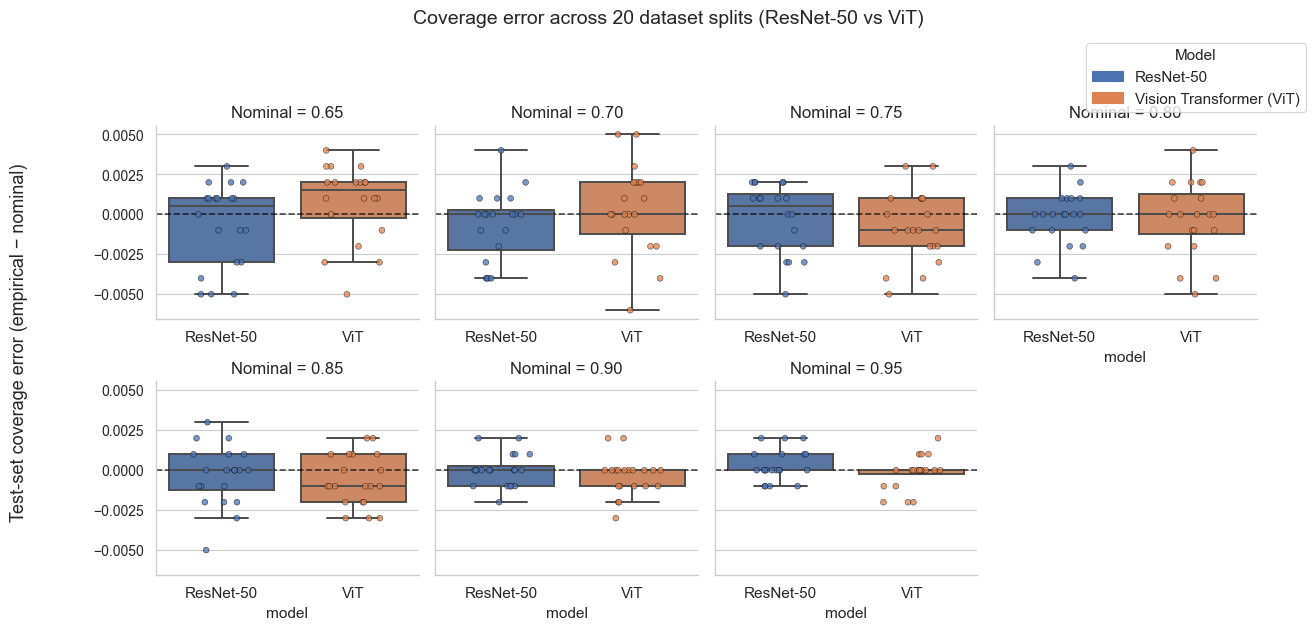

In [19]:
faceted_coverage_error_boxplot_pubready(
    df,
    targets=[0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95],
    out_path="paper_plots/faceted_coverage_error.png",
    ncols=4,
    title="Coverage error across 20 dataset splits (ResNet-50 vs ViT)"
)


# Coverage error MAE vs Nominal (ResNet-50 vs ViT)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_coverage_error_mae_vs_nominal(
    df: pd.DataFrame,
    model_order=("ResNet50", "ViT"),
    out_path=None,
    title="Test-set coverage error MAE vs nominal coverage (ResNet-50 vs ViT)",
    band="sem",
    dpi=300
):

    required = {"model", "target_coverage", "empirical_coverage"}
    if not required.issubset(df.columns):
        raise ValueError(f"df must contain columns {required}")

    d = df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d["empirical_coverage"] = d["empirical_coverage"].astype(float)


    d["abs_err"] = (d["empirical_coverage"] - d["target_coverage"]).abs()


    agg = (
        d.groupby(["model", "target_coverage"])["abs_err"]
         .agg(["mean", "std", "count"])
         .reset_index()
         .rename(columns={"mean": "mae", "std": "sd", "count": "n"})
    )

    if band == "sem":
        agg["err"] = agg["sd"] / np.sqrt(agg["n"])
        band_label = "±1 SEM"
    elif band == "std":
        agg["err"] = agg["sd"]
        band_label = "±1 SD"
    else:
        agg["err"] = 0.0
        band_label = None

    colors = {"ResNet50": "#4C72B0", "ViT": "#DD8452"}  # blue, orange
    labels = {"ResNet50": "ResNet-50 (CNN)", "ViT": "Vision Transformer (ViT)"}

    plt.figure(figsize=(8.2, 5.4), dpi=dpi)

    for m in model_order:
        dm = agg[agg["model"] == m].sort_values("target_coverage")
        x = dm["target_coverage"].values
        y = dm["mae"].values
        e = dm["err"].values

        plt.plot(
            x, y,
            marker="o",
            linewidth=2.2,
            markersize=6,
            color=colors.get(m, None),
            label=labels.get(m, m)
        )

        if band in ("sem", "std"):
            plt.fill_between(
                x, y - e, y + e,
                color=colors.get(m, None),
                alpha=0.18,
                linewidth=0
            )

    plt.xlabel("Nominal (target) coverage")
    plt.ylabel("Test-set coverage error MAE  (mean |empirical − nominal| across runs)")
    plt.title(title)

    plt.grid(True, linestyle="-", linewidth=0.6, alpha=0.35)
    plt.legend(title=("Model " + (f"({band_label})" if band_label else "")), frameon=True)

    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()


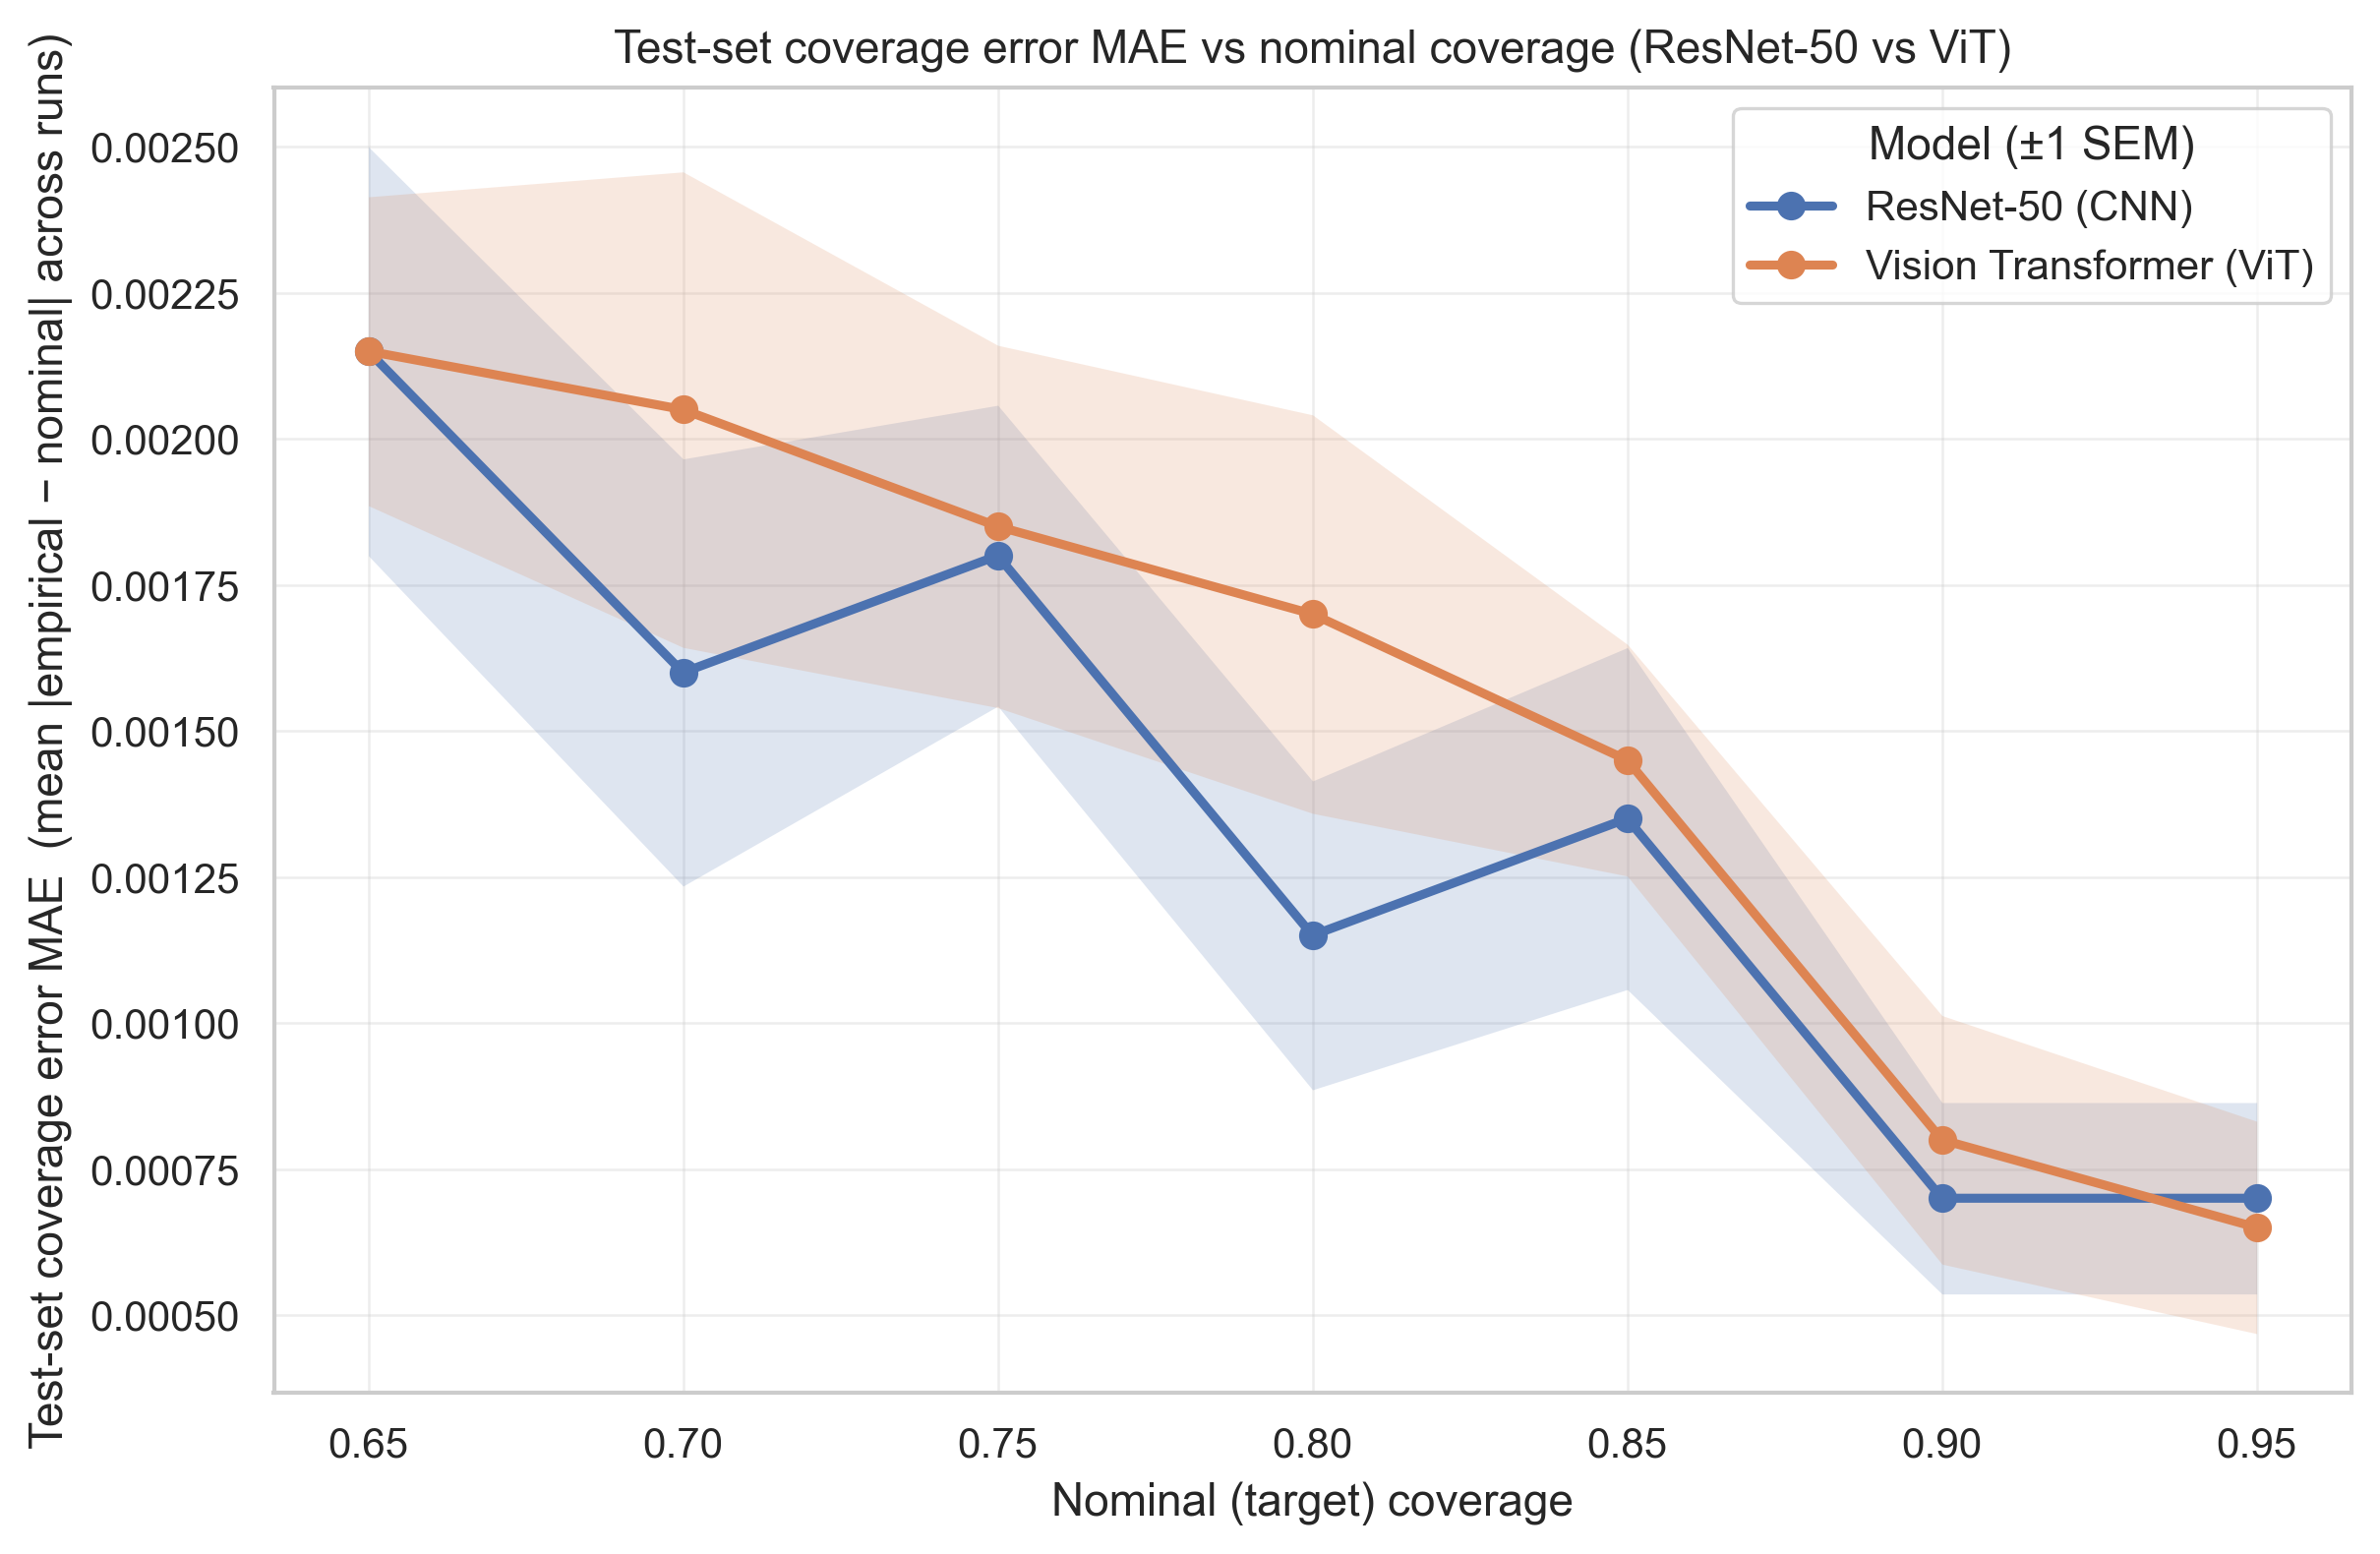

In [21]:
plot_coverage_error_mae_vs_nominal(
    df,
    out_path="paper_plots/coverage_error_mae_vs_nominal.png",
    band="sem"   # or "std" or None
)


# FSC vs Nominal Coverage (Publication-Ready)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple


def plot_avg_set_size_at_nominal(
    df: pd.DataFrame,
    nominal: float = 0.95,
    model_order: Tuple[str, str] = ("ResNet50", "ViT"),
    model_labels: Tuple[str, str] = ("ResNet-50", "Vision Transformer (ViT)"),
    dpi: int = 300,
    out_path: Optional[str] = None,
):
    required = {"model", "run", "target_coverage", "avg_set_size"}
    if not required.issubset(df.columns):
        raise ValueError("df must contain columns: {}".format(required))


    t = round(float(nominal), 2)
    d = df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[d["target_coverage"] == t].copy()

    if d.empty:
        raise ValueError(
            "No rows found for target_coverage={}. Available targets: {}".format(
                t, sorted(df["target_coverage"].astype(float).round(2).unique())
            )
        )


    agg = (
        d.groupby("model")["avg_set_size"]
         .agg(["mean", "std", "count"])
         .reindex(list(model_order))
    )
    agg["sem"] = agg["std"] / np.sqrt(agg["count"])

    means = agg["mean"].values

    # ---- plot
    plt.figure(figsize=(6.2, 4.6), dpi=dpi)

    bars = plt.bar(
        list(model_labels),
        means,
        color=["#4C72B0", "#DD8452"],
        alpha=0.85
    )

    for bar in bars:
        h = bar.get_height()
        plt.annotate(
            "{:.3f}".format(h),
            xy=(bar.get_x() + bar.get_width() / 2, h),
            xytext=(0, 5),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,         
            fontweight="bold"
        )

    plt.ylabel("Average prediction set size")
    plt.title("Average Prediction Set Size at Nominal Coverage = {:.2f} (α = {:.2f})"
              .format(t, 1.0 - t))

    ymin = float(np.min(means)) - 0.02 * float(np.min(means))
    ymax = float(np.max(means)) + 0.02 * float(np.max(means))
    plt.ylim(ymin, ymax)

    plt.grid(True, axis="y", linewidth=0.6, alpha=0.35)
    plt.tight_layout()

    if out_path is not None:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()
    return agg


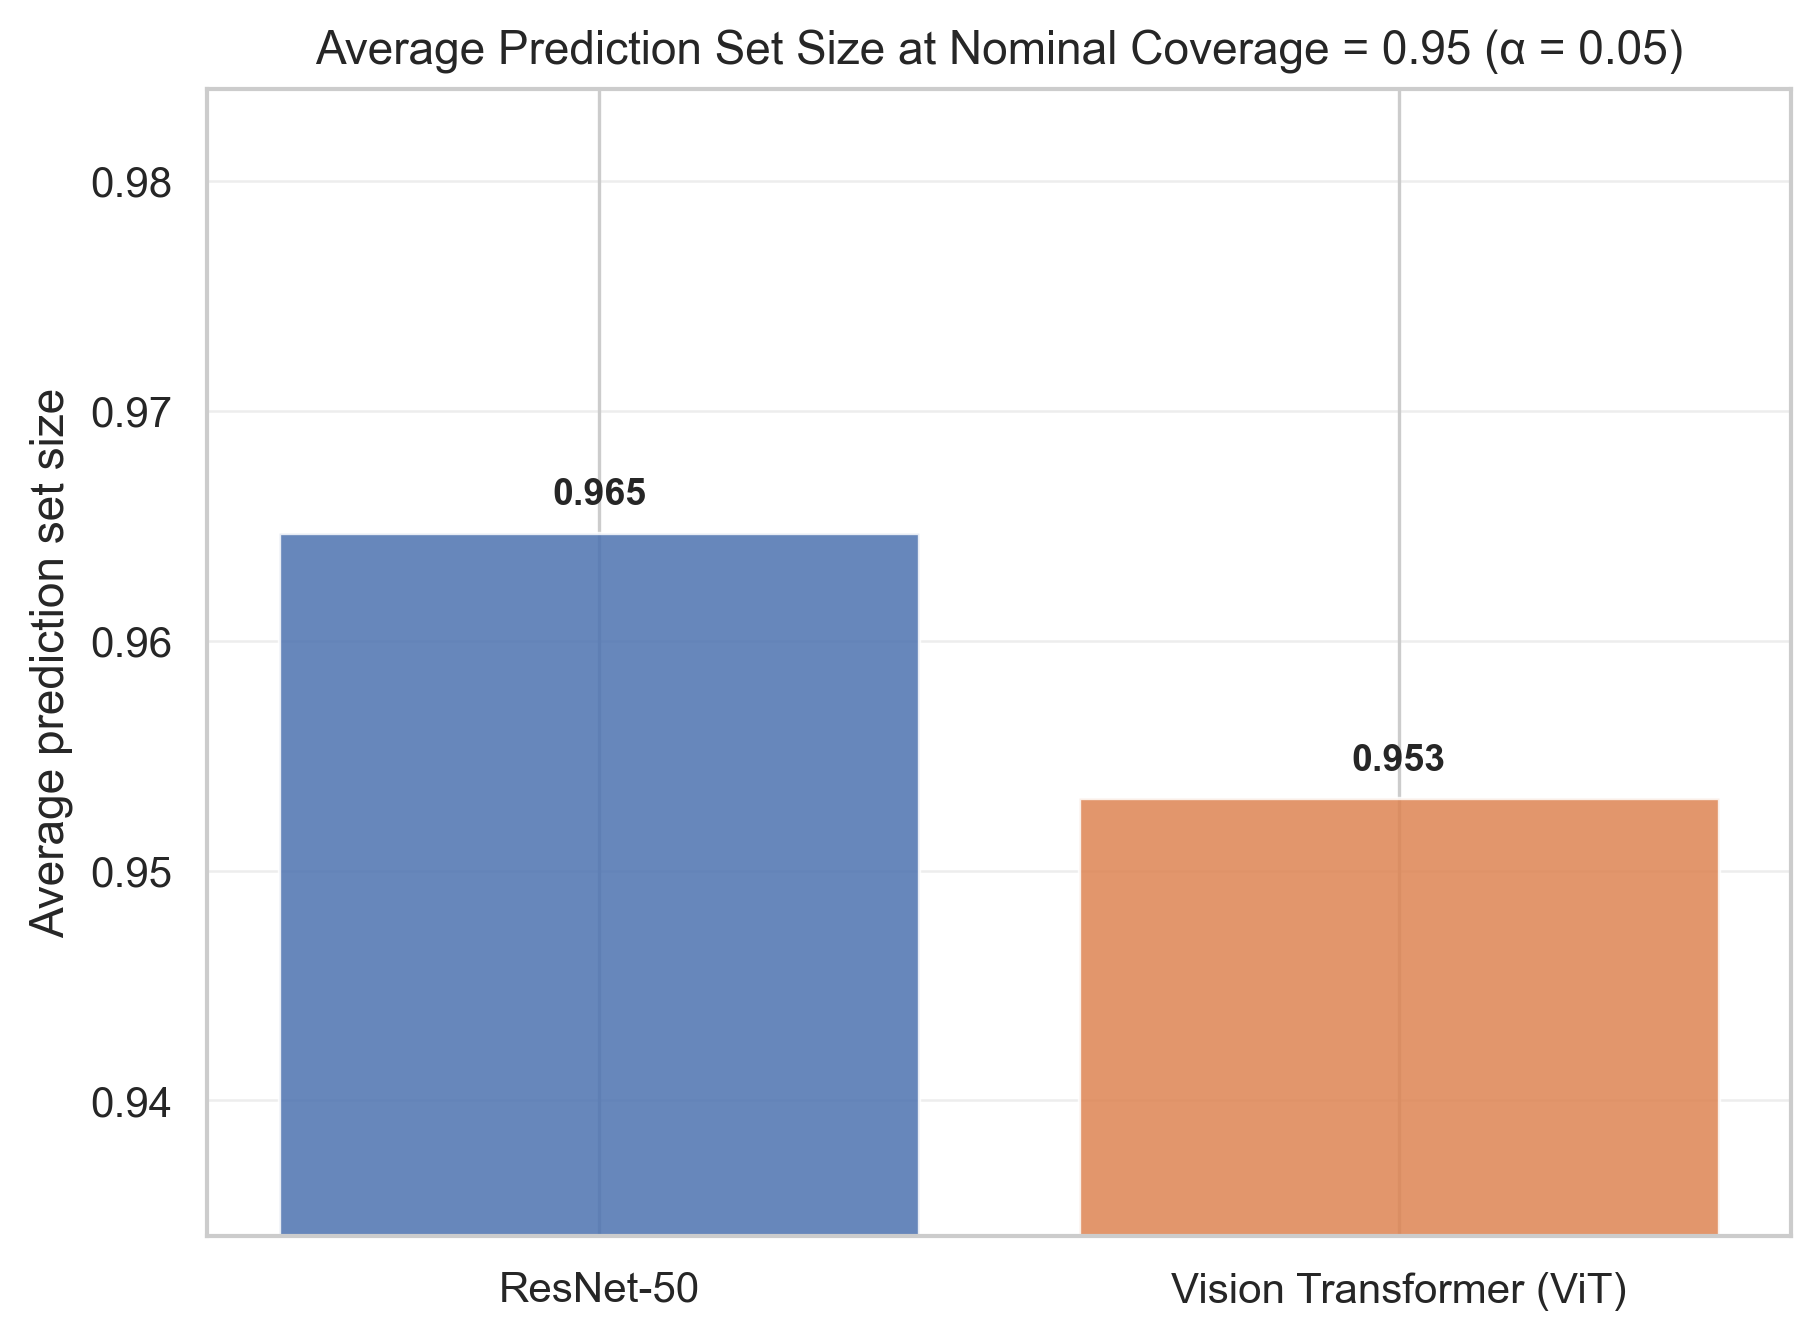

             mean       std  count       sem
model                                       
ResNet50  0.96470  0.001809     20  0.000405
ViT       0.95315  0.001226     20  0.000274


In [33]:
agg_095 = plot_avg_set_size_at_nominal(
    df,
    nominal=0.95,
    out_path="avg_set_size_nominal_0p95.png"
)

print(agg_095)


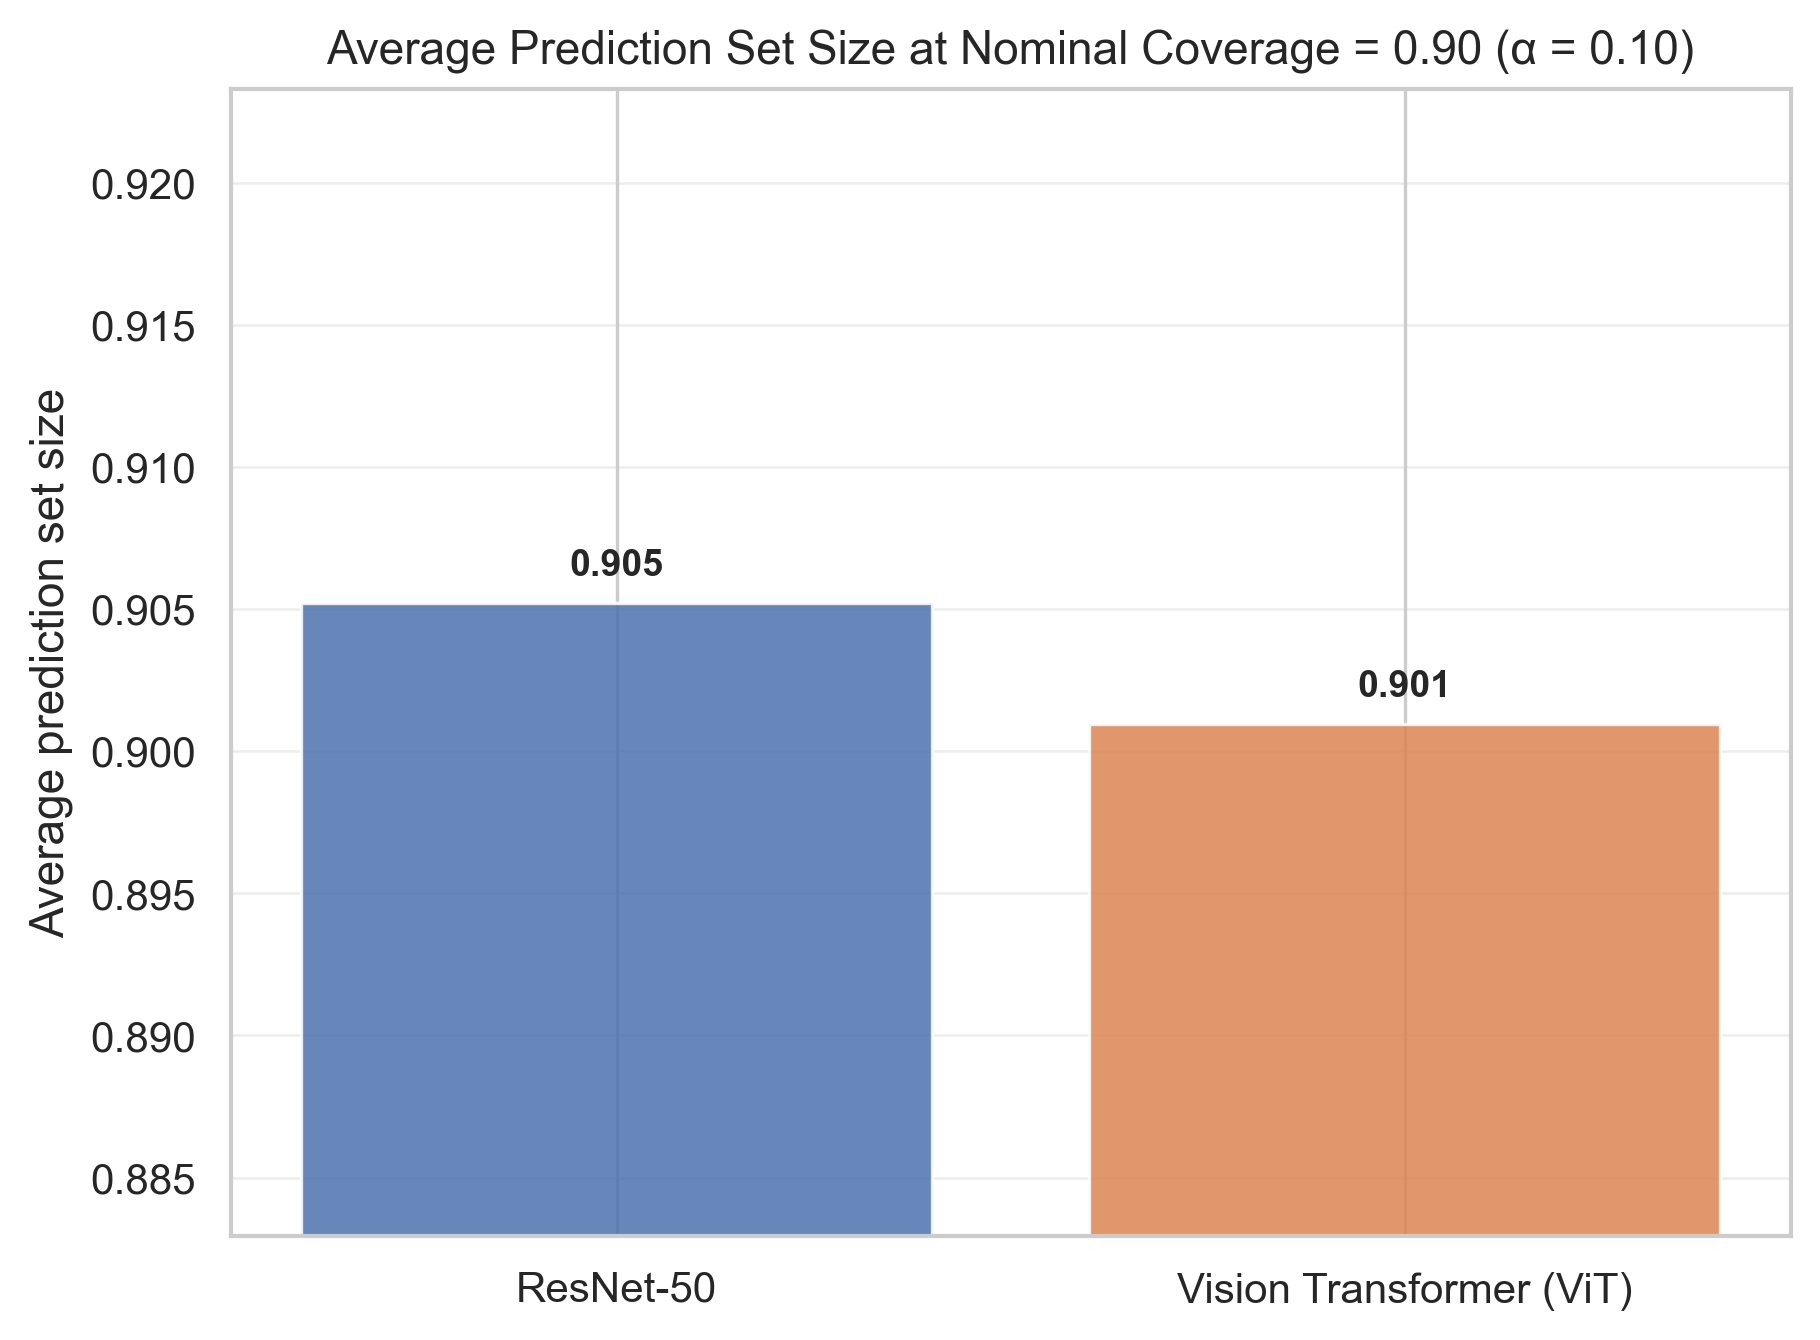

             mean       std  count       sem
model                                       
ResNet50  0.90520  0.001473     20  0.000329
ViT       0.90095  0.001191     20  0.000266


In [34]:
agg_095 = plot_avg_set_size_at_nominal(
    df,
    nominal=0.90,
    out_path="avg_set_size_nominal_0p95.png"
)

print(agg_095)
